# Credit Card Fraud Detection 


# Task 1: Data Understanding, Preparation and Descriptive Analytics

## Required libraries 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import pickle
from scipy.stats import chi2_contingency
from itertools import product
from sklearn.metrics import silhouette_score


## Introduction

This report presents an exploratory analysis of the dataset provided for the Fraud Detection project. The dataset includes transaction records, customer demographics, merchant details, and city-level information. The primary objective of this analysis is to understand the data structure, identify key patterns, and prepare it for predictive modeling to classify transactions as fraudulent or legitimate.



## 1.1- Data Understanding

Data understanding is a critical step in any fraud detection project, as it involves exploring and analyzing the dataset to gain insights into its structure, content, and relevance for identifying fraudulent activities. This will help to ensure that the data aligns with the objectives of the fraud detection system and lays the foundation for effective model development and analysis. 

This phase will involve merging multiple datasets into a cohesive structure, examining the data to understand its content and quality, and summarizing key attributes to uncover initial patterns and relationships.

### 1.1.1- Merge the Datasets

The first step involved merging the datasets to form a unified dataset for analysis. 

I used the function `merge` from pandas library that implements SQL style joining operations.

In this case, `transactions` is our primary dataset, with each row representing a transaction record. I want to ensure that every transaction is retained in the final merged dataset, even if certain demographic, merchant, or city information is missing.

Using `how='left'` for each merge step ensures **all transactions are retained** in the final dataset, even if:

- **Customer data is missing**: Transactions without a matching `cc_num` in `customers` will still appear, with `NaN` for customer details

- **Merchant information is missing**: Transactions lacking a matching `merchant` in `merchants` are included, with `NaN` for merchant fields

- **City data is missing**: If a customer’s `city` has no match in `cities`, the transaction is kept with `NaN` for city details


In [2]:

# Load Datasets
transactions = pd.read_csv('data/transactions.csv')
merchants = pd.read_csv('data/merchants.csv')
customers = pd.read_csv('data/customers.csv')
cities = pd.read_csv('data/cities.csv')

# Merge the .csv files into one
merged_data = pd.merge(transactions, customers, on='cc_num', how='left')
merged_data = pd.merge(merged_data, merchants, on='merchant', how='left')
merged_data = pd.merge(merged_data, cities, on='city', how='left')

# Print merged dataset
print(merged_data.head())

# Save merged dataset into new file
merged_data.to_csv('data/merged_data.csv', index=False)

   index trans_date_trans_time            cc_num device_os     merchant  \
0   5381   2023-01-01 00:39:03  2801374844713453       NaN  Merchant_85   
1   4008   2023-01-01 01:16:08  3460245159749480       NaN  Merchant_23   
2   1221   2023-01-01 01:24:28  7308701990157768     macOS  Merchant_70   
3   9609   2023-01-01 02:06:57  8454886440761098       X11  Merchant_33   
4   5689   2023-01-01 02:10:54  6350332939133843       NaN  Merchant_90   

      amt     trans_num   unix_time  is_fraud  first  ...      job  \
0  252.75  TRANS_662964  1672533543         0   Jane  ...      NaN   
1  340.17  TRANS_134939  1672535768         0  Alice  ...    Nurse   
2   76.38  TRANS_258923  1672536268         0    Bob  ...   Doctor   
3  368.88  TRANS_226814  1672538817         0   Mike  ...  Teacher   
4  323.32  TRANS_668449  1672539054         0   Mike  ...    Nurse   

          dob       category  merch_lat  merch_long merchant_id      lat  \
0  2002-10-12            NaN        NaN   76.433212 

### 1.1.2- Data Examination


After merging, the dataset was examined for its structure and attribute types. Below is a brief description of the key attributes:

| **Attribute**           | **Data Type**       | **Description**                                                                                       |
|--------------------------|---------------------|-------------------------------------------------------------------------------------------------------|
| `index`                 | Categorical  (Nominal)  | Index of the transaction record.                                                                     |
| `trans_date_trans_time` | Categorical (Ordinal)        | Transaction date and time.                                                                           |
| `cc_num`                | Categorical  (Nominal) | Credit card number used for the transaction.                                                         |
| `device_os`             | Categorical (Nominal)       | Operating system of the device used (Windows, macOS, Linux, X11, other).                             |
| `merchant`              | Categorical  (Nominal)       | Name of the merchant involved in the transaction.                                                    |
| `amt`                   | Numerical (Ratio)| Monetary amount of the transaction.                                                                  |
| `trans_num`             | Categorical  (Nominal)       | Unique transaction identifier.                                                                       |
| `unix_time`             | Numerical   (Interval)        | Unix timestamp of the transaction (seconds since January 1, 1970).                                   |
| `is_fraud`              | Categorical (Nominal)  | Indicates if the transaction was fraudulent (1 for fraud, 0 otherwise).                              |
| `category`              | Categorical (Nominal)        | Business category of the merchant (e.g., groceries, travel).                                         |
| `merch_lat`             | Numerical (Interval)| Latitude of the merchant's location.                                                                 |
| `merch_long`            | Numerical (Interval)| Longitude of the merchant's location.                                                                |
| `merchant_id`           | Categorical (Nominal)       | Unique identifier for the merchant.                                                                  |
| `first`                 | Categorical (Nominal)        | Customer's first name.                                                                               |
| `last`                  | Categorical (Nominal)       | Customer's last name.                                                                                |
| `gender`                | Categorical (Nominal)        | Customer's gender.                                                                                   |
| `street`                | Categorical (Nominal)        | Customer's street address.                                                                           |
| `city`                  | Categorical (Nominal)       | City where the customer resides.                                                                     |
| `zip`                   | Categorical (Nominal)        | Zip code of the customer's address.                                                                  |
| `job`                   | Categorical  (Nominal)       | Customer's job/profession.                                                                           |
| `dob`                   | Categorical (Ordinal)         | Customer's date of birth.                                                                            |
| `lat`                   | Numerical (Interval) | Latitude of the city.                                                                                |
| `long`                  |Numerical (Interval)| Longitude of the city.                                                                               |
| `city_pop`              | Numerical (Ratio)        | Population of the city.                                                                              |
| `state`                 | Categorical  (Nominal)      | State where the city is located.                                                                     |


### 1.1.3- Data Summarization


Data summarization is a foundational step that transforms raw data into actionable insights. It ensures that subsequent processes, like data visualization, feature engineering, and modeling, are based on a well-understood dataset, ultimately leading to better analytical outcomes.

In [3]:

# Load the merged dataset
merged_data = pd.read_csv('data/merged_data.csv')

print("General Information:")
print(merged_data.info())


General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  30000 non-null  int64  
 1   trans_date_trans_time  29900 non-null  object 
 2   cc_num                 30000 non-null  int64  
 3   device_os              12036 non-null  object 
 4   merchant               30000 non-null  object 
 5   amt                    29900 non-null  float64
 6   trans_num              30000 non-null  object 
 7   unix_time              30000 non-null  int64  
 8   is_fraud               30000 non-null  int64  
 9   first                  29990 non-null  object 
 10  last                   29990 non-null  object 
 11  gender                 29990 non-null  object 
 12  street                 29990 non-null  object 
 13  city                   29990 non-null  object 
 14  zip                    29784 non-

#### <u>Change data types to correct ones</u>

When working with data, it is common for pandas to infer the data types of each column automatically based on the values it contains. However, some columns that are semantically categorical or identifiers might be mistakenly inferred as numeric. This misclassification can lead to incorrect data interpretation or processing. Below is the rationale for converting specific columns in the merged_data DataFrame:

In [4]:
merged_data['index'] = merged_data['index'].astype('object')
merged_data['cc_num'] = merged_data['cc_num'].astype('object')
merged_data['is_fraud'] = merged_data['is_fraud'].astype('object')
merged_data['zip'] = merged_data['zip'].astype('object')
merged_data['merchant_id'] = merged_data['merchant_id'].astype('object')

print("General Information:")
print(merged_data.info())


General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  30000 non-null  object 
 1   trans_date_trans_time  29900 non-null  object 
 2   cc_num                 30000 non-null  object 
 3   device_os              12036 non-null  object 
 4   merchant               30000 non-null  object 
 5   amt                    29900 non-null  float64
 6   trans_num              30000 non-null  object 
 7   unix_time              30000 non-null  int64  
 8   is_fraud               30000 non-null  object 
 9   first                  29990 non-null  object 
 10  last                   29990 non-null  object 
 11  gender                 29990 non-null  object 
 12  street                 29990 non-null  object 
 13  city                   29990 non-null  object 
 14  zip                    29784 non-

In [5]:
# Select numerical columns excluding irrelevant ones
numerical_columns = merged_data.select_dtypes(include=["number"]).drop(['merch_lat','merch_long','lat','long'], axis=1)

# Display summary statistics for numerical columns
print("\nSummary Statistics for Numerical Variables:")
numerical_columns.describe()


Summary Statistics for Numerical Variables:


,amt,unix_time,city_pop
count,29900.000000,3.000000e+04,1.002000e+04
mean,250.063287,1.705650e+09,3.704410e+06
std,144.106058,1.530499e+07,2.323382e+06
min,1.010000,1.672534e+09,1.680992e+06
25%,125.235000,1.696269e+09,2.328000e+06
50%,249.625000,1.706376e+09,2.716000e+06
75%,375.242500,1.718328e+09,3.979576e+06
max,499.970000,1.730124e+09,8.419600e+06


In [6]:
# Select categorical columns
categorical_columns = merged_data.select_dtypes(include=["object"])

# Display summary statistics for categorical columns
print("\nSummary Statistics for Categorical Variables:")
categorical_columns.describe()



Summary Statistics for Categorical Variables:


,index,trans_date_trans_time,cc_num,device_os,merchant,trans_num,is_fraud,first,last,gender,street,city,zip,job,dob,category,merchant_id,state
count,30000,29900,30000,12036,30000,30000,30000,29990,29990,29990,29990,29990,29784.0,29784,29990,29401,29990.0,10020
unique,29970,29868,1101,5,101,29470,2,108,108,2,102,6,1077.0,7,1062,5,100.0,5
top,2041,2023-10-20 21:24:16,1808228936642008,Windows,Merchant_72,TRANS_600014,0,Jane,Williams,F,Elm St,Test City,39611.0,Lawyer,1965-10-17,Groceries,72.0,CA
freq,2,2,237,3049,339,4,29429,1489,1442,15414,1780,19970,237.0,6443,237,7193,339.0,2181


**Note:**

I removed some atributes from the summary table for numerical variables because these attributes are either irrelevant for descriptive analysis or do not provide meaningful insights in the context of summarization. By excluding these attributes, the summary focuses on numerical variables that have genuine analytical significance.


**Analysis:**

The summary statistics reveal key characteristics of the dataset. Transaction amounts range from small to mid-sized values, with a mean of 250.06, indicating a relatively consistent distribution. Fraudulent transactions are rare, accounting for only 1.9% of the data, highlighting a significant class imbalance that must be addressed during modeling. device_os has a high proportion of missing values, while "Test City" dominates the city field, likely indicating synthetic or placeholder data. The dataset includes a diverse set of merchants and categories, with "Groceries" being the most frequent category. These insights emphasize the need to handle missing values, investigate synthetic data, and carefully address class imbalance to ensure effective analysis and modeling.

#### <u>Correlation Matrix</u>

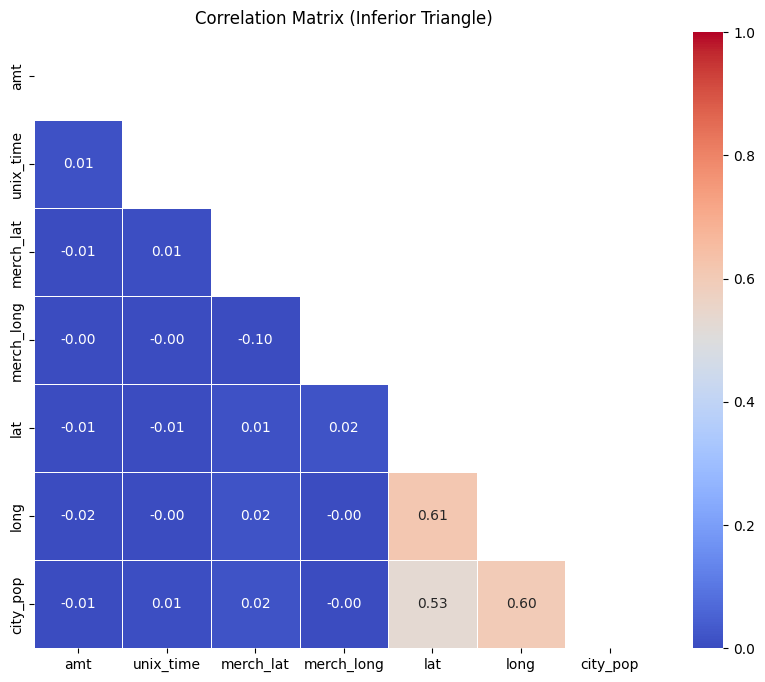

In [7]:
relevant_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
filtered_data = merged_data[relevant_columns]


correlation_matrix = filtered_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=0, vmax=1)
plt.title('Correlation Matrix (Inferior Triangle)')
plt.show()

The correlation matrix provides valuable insights into the relationships between various features in the dataset. Based on the analysis, the following observations can be highlighted:

The majority of the variables exhibit very weak correlations, with values close to zero. This suggests minimal or no linear relationships between these features. For instance, variables such as `amt` (transaction amount), `unix_time` (timestamp), `merch_lat` (merchant latitude), and `merch_long` (merchant longitude) show negligible correlations with other variables in the dataset.

A notable exception is observed in the relationship between geographical coordinates. The latitude (`lat`) and longitude (`long`) variables display a moderate positive correlation of **0.61**. This indicates that there may be a geographical clustering pattern in the data. Such patterns could reflect regional trends, but further analysis would be necessary to determine their significance in the context of fraud detection.

Additionally, the city population (`city_pop`) variable demonstrates moderate positive correlations with both `lat` (**0.53**) and `long` (**0.60**). These correlations suggest that cities with larger populations might be concentrated within specific geographical regions, likely due to urbanization trends or demographic factors.

From a fraud detection perspective, the weak correlations among most features suggest that simple linear relationships are unlikely to provide meaningful insights for identifying fraudulent behavior. Instead, it may be necessary to explore non-linear relationships, interactions between variables, or employ advanced analytical techniques such as machine learning to uncover hidden patterns in the data.


#### <u>Chi-Square Test</u>

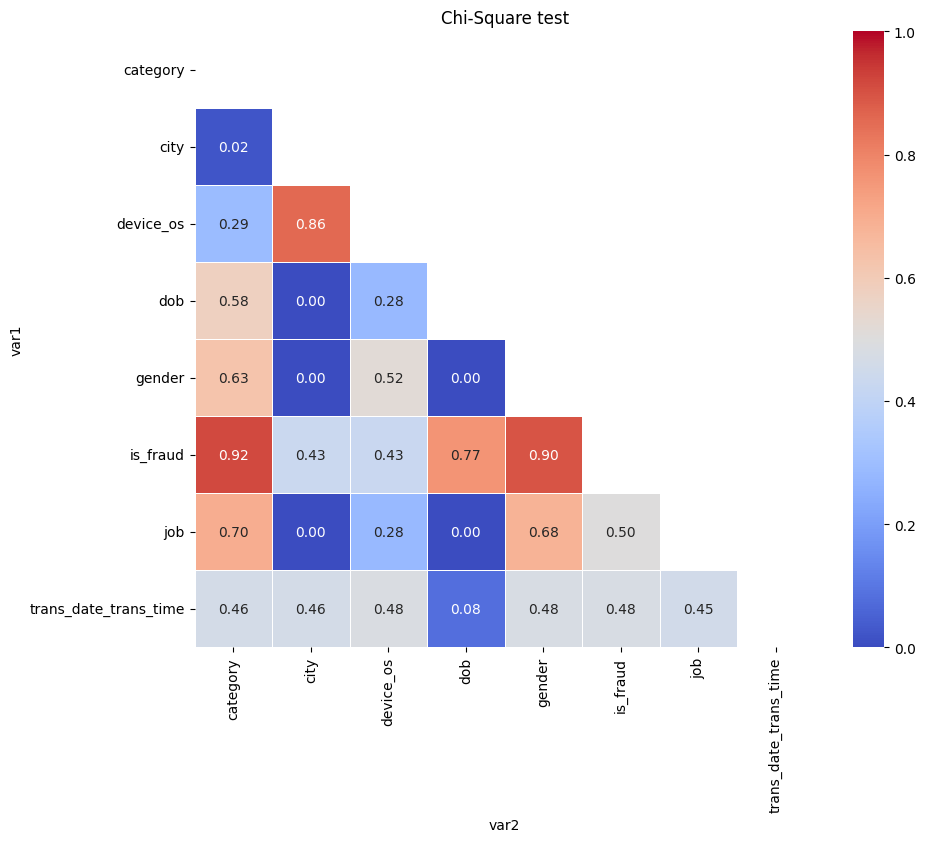

In [8]:
# Chi-Square test

categorical_columns = categorical_columns.dropna()
data = categorical_columns.drop(['index', 'first', 'last', 'cc_num', 'trans_num', 'state', 'street', 'zip', 'merchant_id','merchant'], axis=1)


prod = product(data, repeat = 2)

result = []
for col1, col2 in prod:
    if col1 != col2:
        result.append((col1,col2,list(chi2_contingency(pd.crosstab(data[col1], data[col2])))[1]))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff']) 
chi_matrix = chi_test_output.pivot(index='var1', columns='var2', values='coeff')
chi_matrix.fillna(1, inplace=True)


mask = np.triu(np.ones_like(chi_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(chi_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5,vmin=0, vmax=1)
plt.title("Chi-Square test")
plt.show()


In the Chi-Square test heatmap, lower values indicate stronger relationships between the variables, which is desirable in this analysis as it highlights statistical dependence. The Chi-Square test operates under the null hypothesis (H₀) that the variables are independent, meaning there is no association between them. Lower values (often corresponding to lower p-values) provide evidence to reject the null hypothesis, suggesting that the variables are not independent and are, therefore, associated.

Using a significance threshold of 0.05, variables with values below this level indicate a statistically significant relationship. These relationships are particularly valuable in data analysis as they suggest patterns or dependencies that can inform decision-making, segmentation, or predictive modeling. For instance, variables like gender and dob or job and dob exhibit low values in the heatmap, highlighting meaningful dependencies that warrant further exploration. Conversely, higher values suggest independence and less relevance for understanding correlations.

Thus, the lower the value in the heatmap, the more likely it is that the variables are correlated, providing critical insights into their potential interdependence.

### 1.1.4- Data Visualization

Data visualization is an essential step in understanding and presenting data. It simplifies complex information, uncovers hidden patterns, and supports informed decision-making. By using appropriate visualization techniques, analysts can effectively interpret relationships, trends, and anomalies, setting the stage for robust data preparation and modeling.

#### <u>Fraud distribution</u>

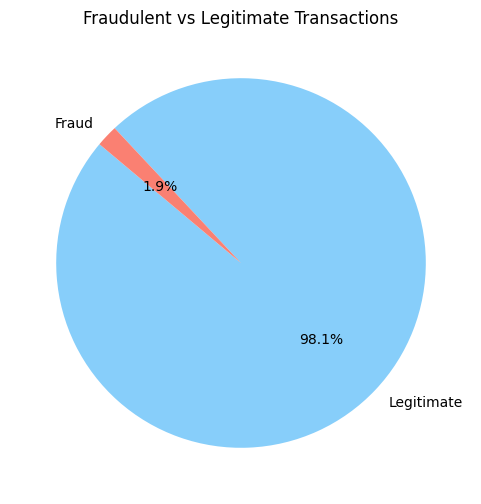

In [9]:
# Pie chart plot
fraud_counts = merged_data['is_fraud'].value_counts(normalize=True)
labels = ['Legitimate', 'Fraud']
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'salmon'])
plt.title('Fraudulent vs Legitimate Transactions')
plt.show()

**What was done:**

A pie chart was created to visualize the proportion of fraudulent transactions (`is_fraud` = 1) versus legitimate transactions (`is_fraud` = 0). The values were normalized to show the percentage distribution.

**Analysis:**

The chart reveals a significant class imbalance, with fraudulent transactions accounting for only 1.9% of all transactions. This imbalance highlights the importance of addressing this issue during model training, as it may lead to biased predictions favoring the majority class (legitimate transactions). Techniques like oversampling, undersampling, or cost-sensitive modeling will be essential.

#### <u>Distribution of transaction amount</u>

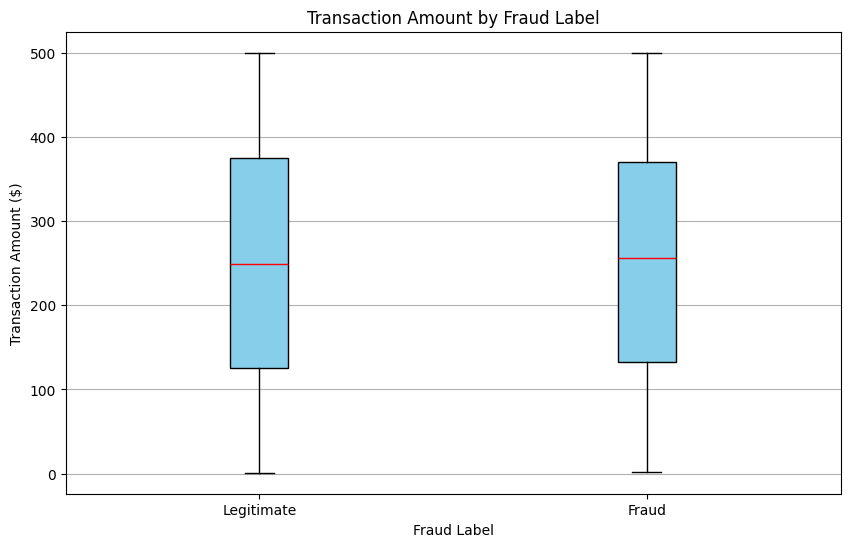

In [10]:

# Filter data for visualization
fraud = merged_data[merged_data['is_fraud'] == 1]['amt']
legit = merged_data[merged_data['is_fraud'] == 0]['amt']

# Limit the range for better visualization
fraud = fraud[fraud <= 500]
legit = legit[legit <= 500]

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot([legit, fraud], tick_labels=['Legitimate', 'Fraud'], patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Transaction Amount by Fraud Label')
plt.xlabel('Fraud Label')
plt.ylabel('Transaction Amount ($)')
plt.grid(axis='y')
plt.show()

**What was done:**

A box plot was created to compare the transaction amounts for fraudulent and legitimate transactions. To improve visibility, the range was limited to transactions under $500, because there are no transactions above that value.

**Analysis:**

The box plot shows that fraudulent transactions tend to have higher median amounts compared to legitimate ones. This suggests that fraudsters may target higher-value transactions. However, there is overlap between the distributions, indicating that transaction amount alone may not be a definitive predictor of fraud.

#### <u>Fraud rate by merchant category</u>

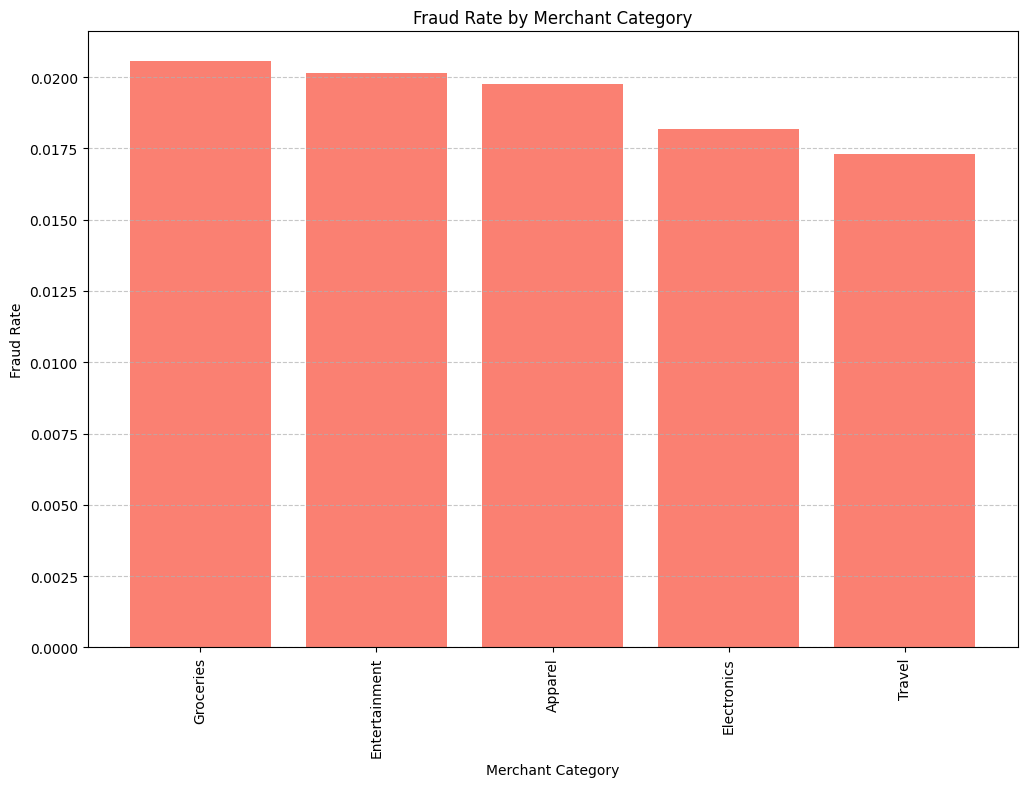

In [11]:

fraud_rate = merged_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12, 8))
plt.bar(fraud_rate.index, fraud_rate.values, color='salmon')
plt.xticks(rotation=90)
plt.title('Fraud Rate by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Fraud Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

A bar plot was used to display the average fraud rate for each merchant category, calculated by grouping the data by `category` and taking the mean of `is_fraud`.

**Analysis:**

The chart reveals that certain merchant categories, such as "Groceries" and "Entertainment," have slightly higher fraud rates. This insight could be useful for identifying high-risk merchant categories. However, the differences between categories are not dramatic, suggesting that other factors may play a more significant role in fraud.

#### <u>OS Used in Transactions</u>

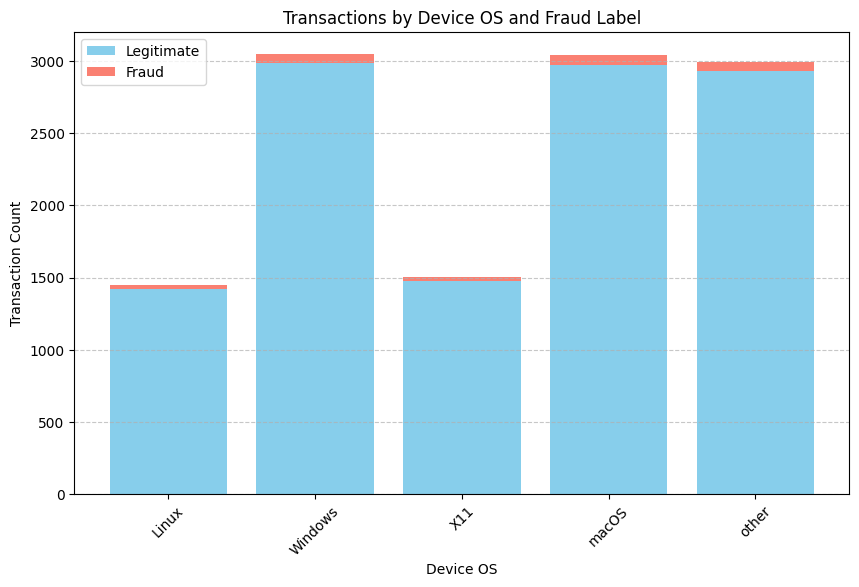

In [12]:
# Count of transactions by device_os and fraud label
device_os_counts = merged_data.groupby(['device_os', 'is_fraud']).size().unstack(fill_value=0)

# Stacked bar plot
device_os = device_os_counts.index
legit_counts = device_os_counts[0]
fraud_counts = device_os_counts[1]

x = range(len(device_os))
plt.figure(figsize=(10, 6))
plt.bar(x, legit_counts, label='Legitimate', color='skyblue')
plt.bar(x, fraud_counts, label='Fraud', bottom=legit_counts, color='salmon')

plt.xticks(x, device_os, rotation=45)
plt.title('Transactions by Device OS and Fraud Label')
plt.xlabel('Device OS')
plt.ylabel('Transaction Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**What was done:**

A stacked bar plot was created to compare the number of transactions for each device_os, split by fraud label (is_fraud).

**Analysis:**

The chart shows that Windows and macOS have the highest number of both legitimate and fraudulent transactions, likely reflecting their popularity among users. However, the proportion of fraudulent transactions does not vary significantly across operating systems. This indicates that device OS may not be a strong standalone feature for fraud detection.

#### <u>Fraud Rate by City</u>

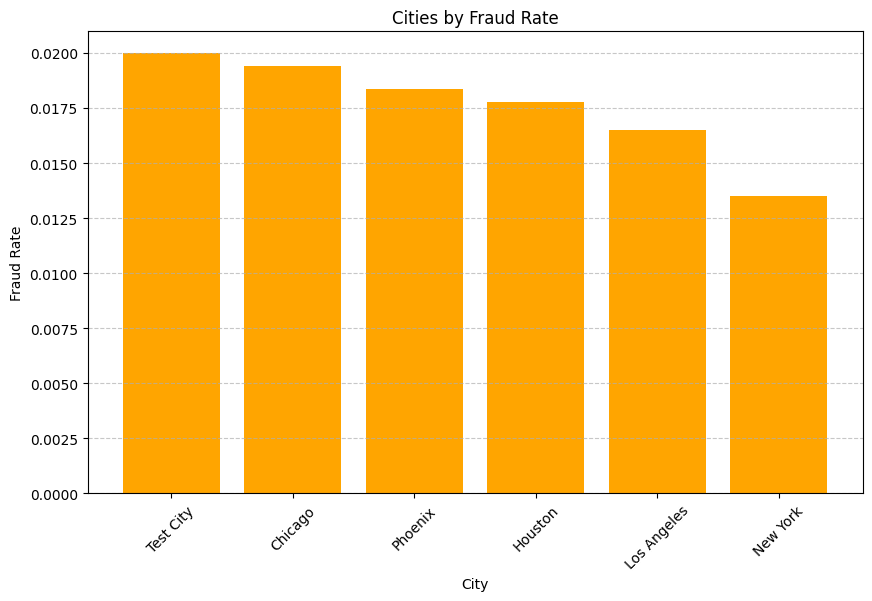

In [13]:
# Calculate fraud rate per city
city_fraud_rate = merged_data.groupby('city')['is_fraud'].mean().sort_values(ascending=False)

# Bar plot for fraud rate by city
plt.figure(figsize=(10, 6))
plt.bar(city_fraud_rate.index, city_fraud_rate.values, color='orange')
plt.title('Cities by Fraud Rate')
plt.xlabel('City')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

A bar plot was created to show the cities with the highest fraud rates. The fraud rate for each city was calculated as the mean of `is_fraud`.

**Analysis:**

The chart indicates that major metropolitan areas such as Chicago, Phoenix and Houston have higher fraud rates. Upon further inspection, the inclusion of "Test City" appears to be a synthetic or placeholder entry in the dataset rather than a real location. This type of entry is likely used for testing purposes or as a default value and does not represent actual transactional data.

Its presence can distort the analysis by introducing artificial patterns or biasing the interpretation of fraud rates. For this reason, "Test City" should be excluded from the analysis to ensure that insights are based solely on genuine and reliable data. Further exploration of the relationship between fraud rates and factors such as city population, transaction volume, or merchant density can help uncover the underlying dynamics contributing to higher fraud rates in specific cities.

#### Fraud Rate by Customer Age 

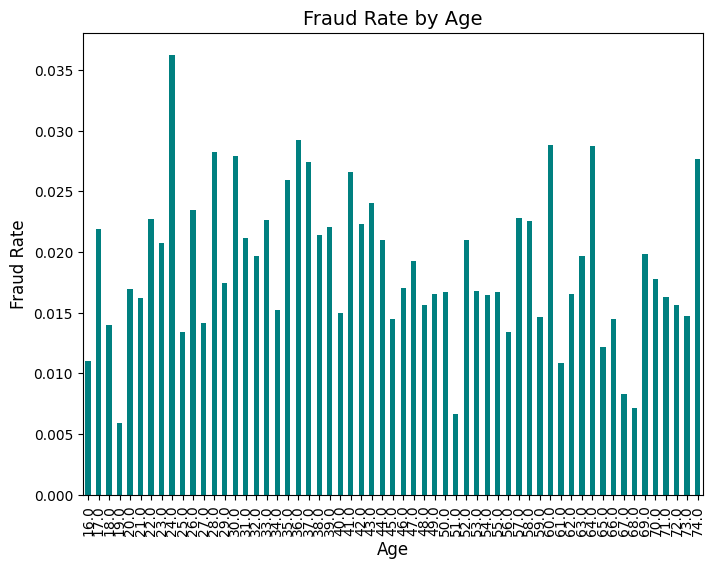

In [14]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365


# Calculate fraud rate by age group
fraud_rate_by_age = merged_data.groupby('age')['is_fraud'].mean()


merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)

# Bar plot
plt.figure(figsize=(8, 6))
fraud_rate_by_age.plot(kind='bar', color='teal')
plt.title('Fraud Rate by Age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.show()


**What was done:**

A bar plot was created to display the fraud rate for each specific age. The fraud rate for each age was calculated as the mean of the `is_fraud` indicator for transactions associated with individuals of that age.

**Analysis:**

The chart shows fluctuations in the fraud rate across different ages, with no clear monotonic trend. Certain ages exhibit higher fraud rates, such as individuals in their early 30s and late 50s, suggesting potential vulnerabilities or behaviors specific to these age ranges that might increase their susceptibility to fraudulent activities.

The variability in fraud rates across individual ages might reflect differences in transaction habits, levels of digital literacy, or exposure to fraud-prone transaction types. This pattern could also be influenced by age-related factors such as financial activity, reliance on online transactions, or participation in specific industries.

To make the analysis more interpretable, it could be beneficial to group ages into broader ranges (e.g., 18–25, 26–35, etc.) to identify overarching trends. Additionally, cross-referencing fraud rates with external factors such as transaction volume, types of merchants involved, or even income levels could uncover the underlying causes of the observed age-related patterns in fraud rates.


### Fraud Rate by Customer Age Group

/tmp/ipykernel_17156/1835065603.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_age = merged_data.groupby('age_group')['is_fraud'].mean()


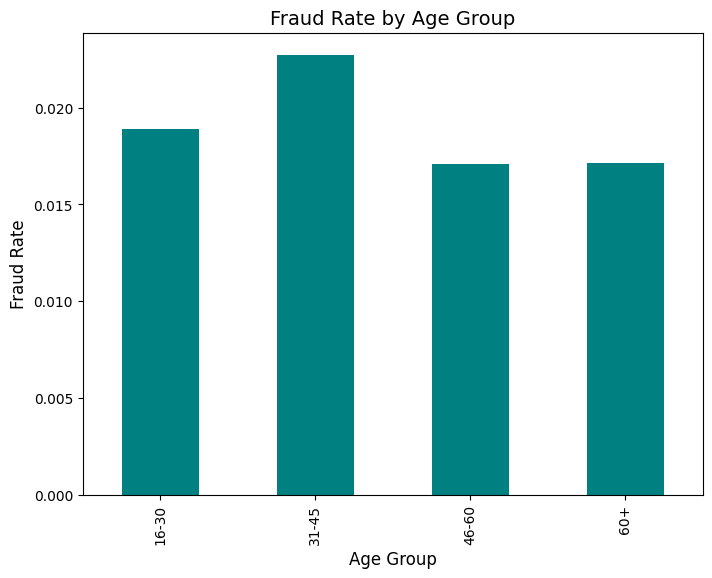

In [15]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')


# Calculate fraud rate by age group
fraud_rate_by_age = merged_data.groupby('age_group')['is_fraud'].mean()

merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)

# Bar plot
plt.figure(figsize=(8, 6))
fraud_rate_by_age.plot(kind='bar', color='teal')
plt.title('Fraud Rate by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.show()

**What was done:**

The bar chart displays the fraud rate across different age groups.

**Analysis**:

Fraud rates are higher among individuals aged 31-45, suggesting that these groups may be more frequently targeted by fraudsters or engage more in high-risk transaction behaviors. Conversely, the fraud rate is lower for individuals aged 60+ and 46-60, which could be due to lower transaction volumes or more cautious spending habits in this demographic. While the differences between age groups are not drastic, these insights could inform targeted fraud prevention strategies for higher-risk groups.

#### Fraud Rate by Merchant Category and Age Group

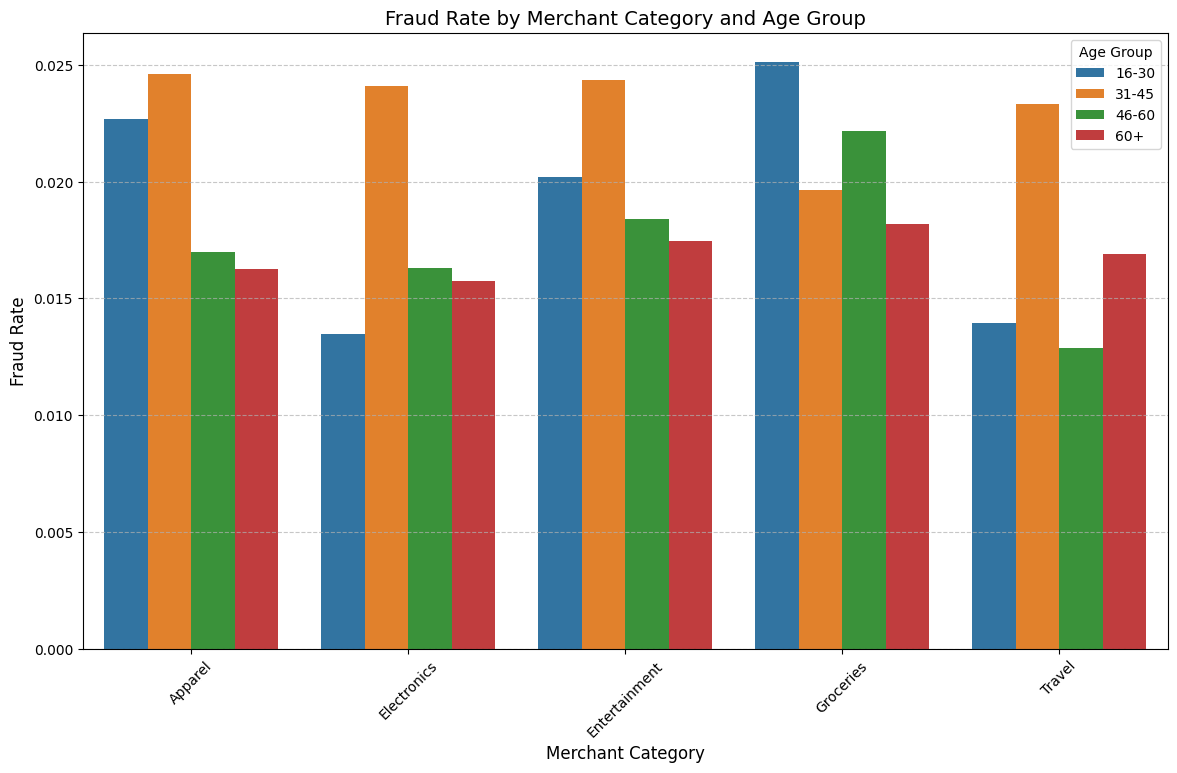

In [16]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')


# Group data by age group and merchant category, then calculate fraud rate
fraud_rate_by_category_age = merged_data.groupby(['age_group', 'category'], observed=True)['is_fraud'].mean().reset_index()

merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)

# Plot a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=fraud_rate_by_category_age, x='category', y='is_fraud', hue='age_group', errorbar=None)
plt.title('Fraud Rate by Merchant Category and Age Group', fontsize=14)
plt.xlabel('Merchant Category', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

The bar chart shows the fraud rate across merchant categories for different age groups. 

**Analysis:**

Younger groups have higher fraud rates in categories like Apparel and Travel, while middle-aged groups (31-45) show peaks in Entertainment and electronics. Older groups (60+ and 46-60) generally experience lower fraud rates across categories. These patterns suggest that fraudsters may target specific demographics based on category-related behaviors, such as younger individuals in Apparel and Travel or middle-aged individuals in Entertainment. 

#### Fraud Rate by Hour of Day

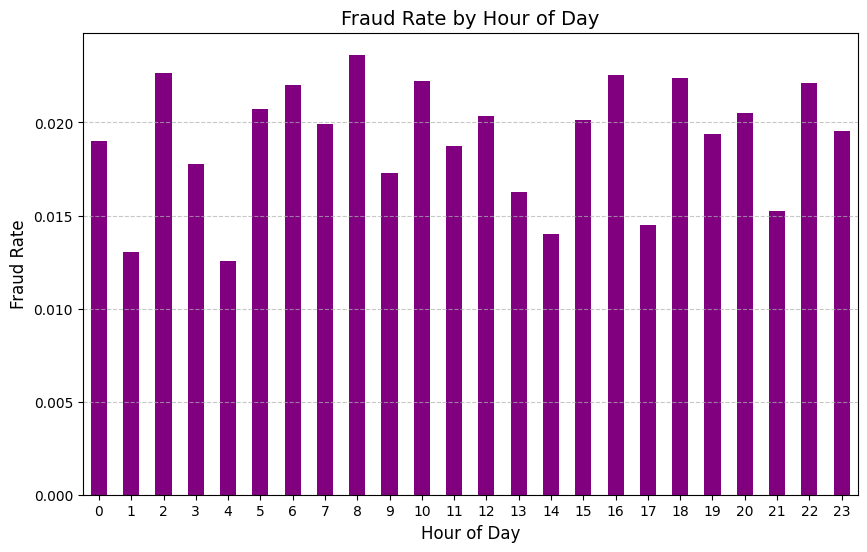

In [17]:
# Convert Unix time to datetime and extract the hour
merged_data['hour'] = pd.to_datetime(merged_data['unix_time'], unit='s').dt.hour

# Group by hour and calculate fraud rate
fraud_rate_by_hour = merged_data.groupby('hour')['is_fraud'].mean()

merged_data.drop('hour', axis=1, inplace=True)

# Bar plot
plt.figure(figsize=(10, 6))
fraud_rate_by_hour.plot(kind='bar', color='purple')
plt.title('Fraud Rate by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**What was done:**

A bar plot was created to show the fraud rate distribution across the 24 hours of the day. The fraud rate for each hour was calculated as the mean of the `is_fraud` indicator for transactions that occurred within that specific hour.

**Analysis:**

The chart reveals that the fraud rate varies throughout the day, with noticeable peaks during early morning hours (around 2 AM and 8 AM) and late afternoon hours (around 4 PM to 6 PM). These time periods may correspond to specific transaction patterns or vulnerabilities exploited by fraudulent actors.

The lower fraud rates observed during some periods, such as late night (e.g., 1 AM and 4 AM), could reflect reduced transaction volumes or differences in user behavior during these hours. Conversely, the higher fraud rates during business hours might align with higher transaction activity or targeted fraudulent schemes during periods of high financial activity.


#### Distribution of Time of Day by Fraud

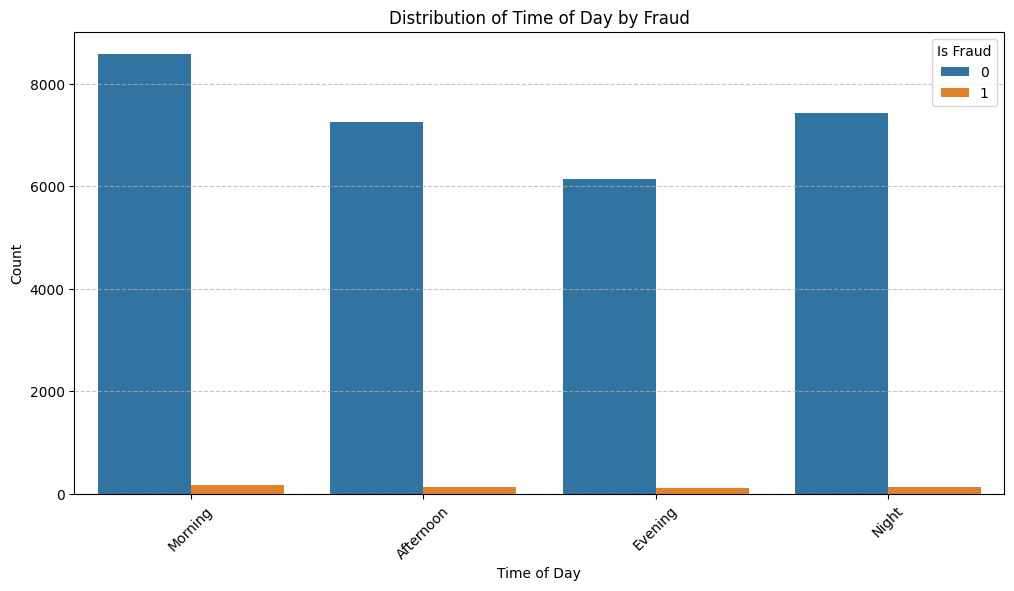

In [18]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

# Convert Unix time to datetime and extract the hour
merged_data['transaction_hour'] = pd.to_datetime(merged_data['unix_time'], unit='s').dt.hour

merged_data['time_of_day'] = merged_data['transaction_hour'].apply(get_time_of_day)
# Plot da distribuição de `time_of_day` por fraude


plt.figure(figsize=(12, 6))
sns.countplot(data=merged_data, x='time_of_day', hue='is_fraud', order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Distribution of Time of Day by Fraud')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is Fraud', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


merged_data.drop('transaction_hour', axis=1, inplace=True)
merged_data.drop('time_of_day', axis=1, inplace=True)

**What was done:**

This bar plot visualizes the fraud rate across different hours of the day. The hour was extracted from the unix_time column, and the fraud rate (is_fraud) was calculated as the mean of fraud labels for each hour. This provides insight into the temporal patterns of fraudulent activity.

**Analysis:**

While there are peaks and dips, the fraud rate does not vary drastically across hours, suggesting that fraud occurs throughout the day with certain periods being slightly riskier.

#### Geographic Distribution of Fraudulent Transactions and Cities

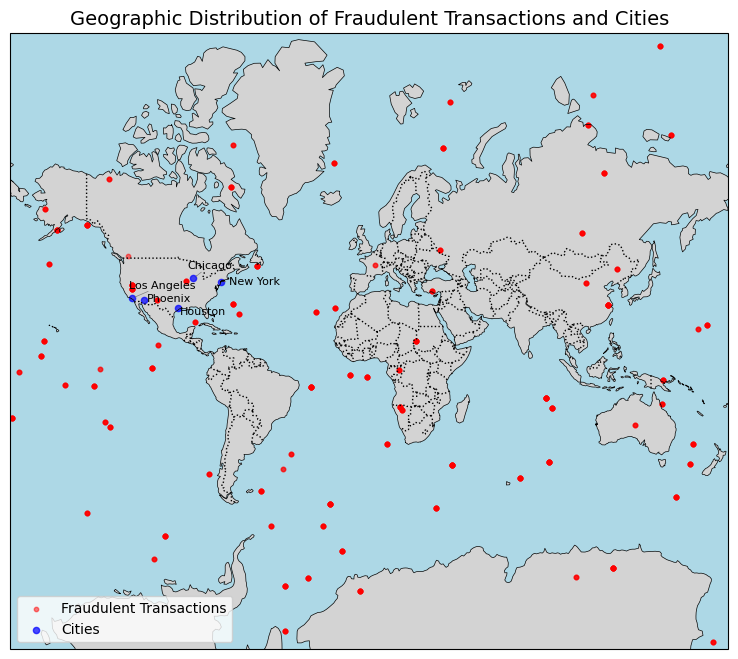

In [19]:
# Filter fraudulent transactions
fraud_data = merged_data[merged_data['is_fraud'] == 1]

# Filter unique cities with valid coordinates
city_data_clean = merged_data[['city', 'lat', 'long']].drop_duplicates().dropna(subset=['lat', 'long'])

# Create a figure and set up a map projection (Mercator)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot fraudulent transactions as scatter points
plt.scatter(
    fraud_data['merch_long'], fraud_data['merch_lat'],
    color='red', alpha=0.5, s=10, transform=ccrs.PlateCarree(),
    label='Fraudulent Transactions'
)

# Plot city locations as blue scatter points
plt.scatter(
    city_data_clean['long'], city_data_clean['lat'],
    color='blue', alpha=0.7, s=20, transform=ccrs.PlateCarree(),
    label='Cities'
)

# Add city labels with adjustText
texts = []
for _, row in city_data_clean.iterrows():
    texts.append(plt.text(
        row['long'], row['lat'], row['city'],
        fontsize=8, transform=ccrs.PlateCarree(), color='black'
    ))
# Adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

# Add title and legend
plt.title('Geographic Distribution of Fraudulent Transactions and Cities', fontsize=14)
plt.legend(loc='lower left', fontsize=10)

# Set extent (map boundaries) based on the data
plt.gca().set_extent([
    min(city_data_clean['long'].min(), fraud_data['merch_long'].min()) - 1,
    max(city_data_clean['long'].max(), fraud_data['merch_long'].max()) + 1,
    min(city_data_clean['lat'].min(), fraud_data['merch_lat'].min()) - 1,
    max(city_data_clean['lat'].max(), fraud_data['merch_lat'].max()) + 1
], crs=ccrs.PlateCarree())

# Show the plot
plt.show()


**What was done:**

The map shows the geographic distribution of fraudulent transactions (red points) overlaid with city locations (blue points). To improve readability, city labels were dynamically adjusted using the adjustText library to avoid overlapping, with arrows indicating their original positions.

**Analysis:**

While some fraudulent transactions are near major urban centers like New York, Chicago, and Los Angeles, many points appear as outliers, such as those in the ocean or sparsely populated regions. This suggests that the geographic coordinates may lack strong correlation with city locations, likely due to errors or placeholders in the dataset. However, there are clusters of fraudulent transactions near certain cities that could warrant further analysis to identify potential patterns or high-risk areas.

### Fraud Rate by Job

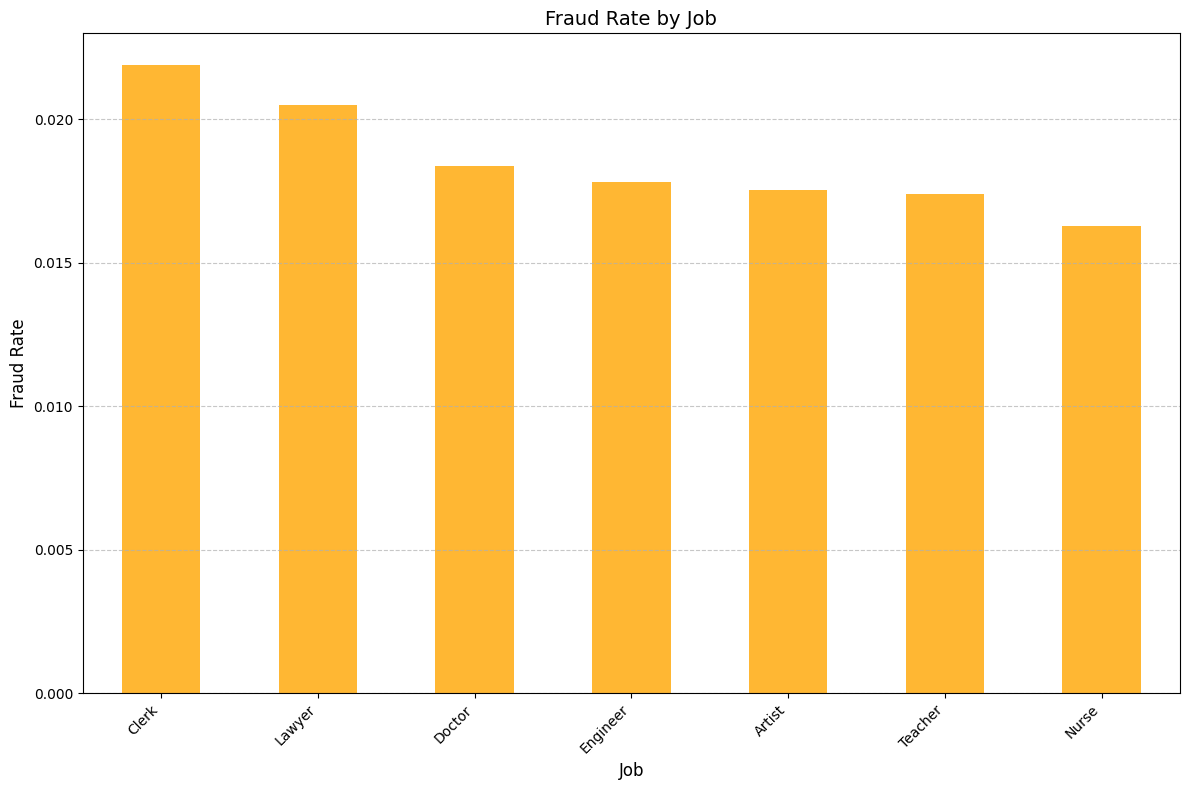

In [20]:
# Calculate fraud rate for each job
fraud_rate_by_job = merged_data.groupby('job')['is_fraud'].mean().sort_values(ascending=False)

# Plot the fraud rate by job
plt.figure(figsize=(12, 8))
fraud_rate_by_job.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Fraud Rate by Job', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**What was done:**

A bar chart was created to analyze the relationship between customers' jobs and the fraud rate.

**Analysis:**

The chart shows that certain professions, such as Clerks and Lawyers, have slightly higher fraud rates compared to other professions like Teachers and Nurses. These differences might reflect behavioral patterns, spending habits, or exposure to fraud based on the nature of the profession. The fraud rates across jobs are relatively close, indicating that job type alone may not be a strong predictor of fraud but could be considered alongside other features

### Fraud Rate by Job and Age group

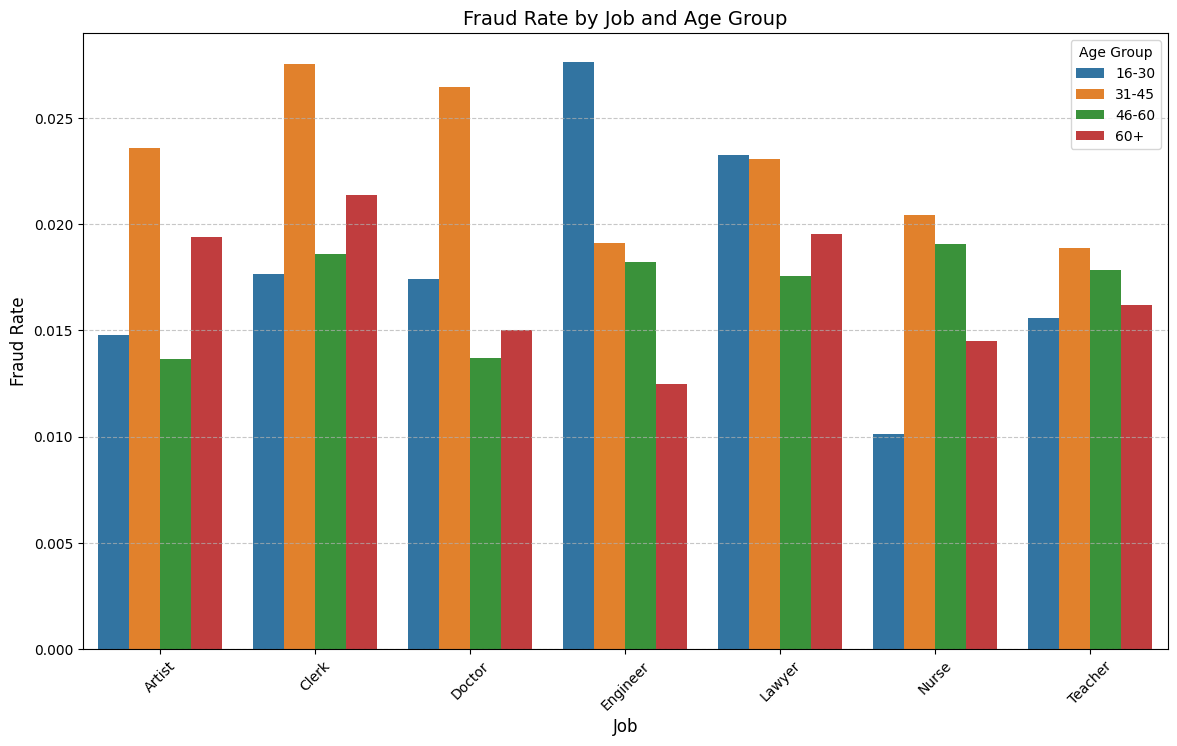

In [21]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')


# Group data by age group and job, then calculate fraud rate
fraud_rate_by_job = merged_data.groupby(['age_group', 'job'], observed=True)['is_fraud'].mean().reset_index()

merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)

# Plot a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=fraud_rate_by_job, x='job', y='is_fraud', hue='age_group', errorbar=None)
plt.title('Fraud Rate by Job and Age Group', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Job Distribution by Age Group

#### Distribution of Categories by City

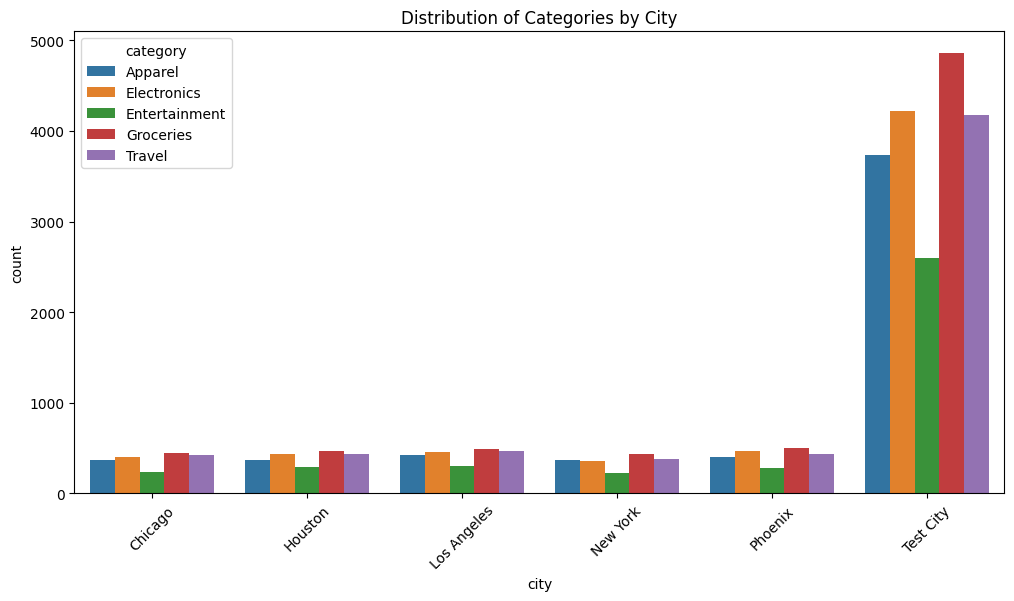

In [22]:
category_city_count = merged_data.groupby(['city', 'category']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(data=category_city_count, x='city', y='count', hue='category')
plt.title("Distribution of Categories by City")
plt.xticks(rotation=45)
plt.show()

#### Gender Distribution by Age Group

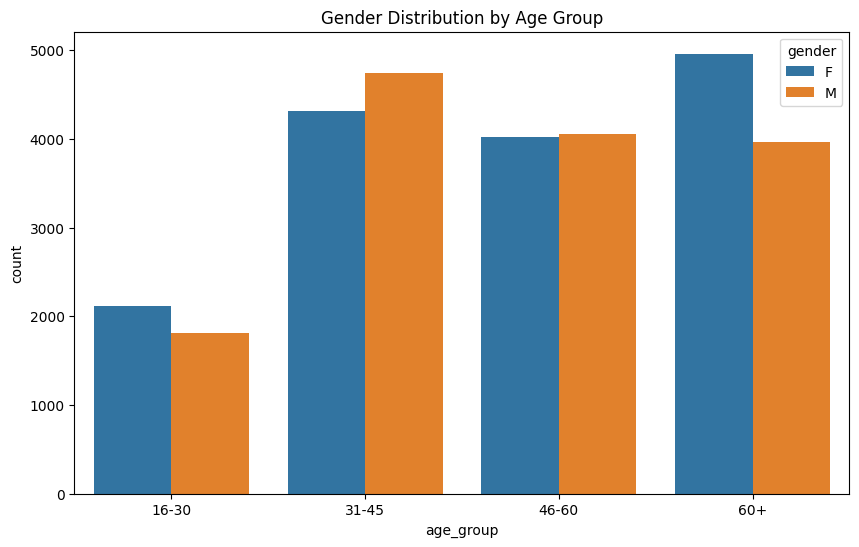

In [23]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

# Bin age into groups
bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')

plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='age_group', hue='gender')
plt.title("Gender Distribution by Age Group")
plt.show()


merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)



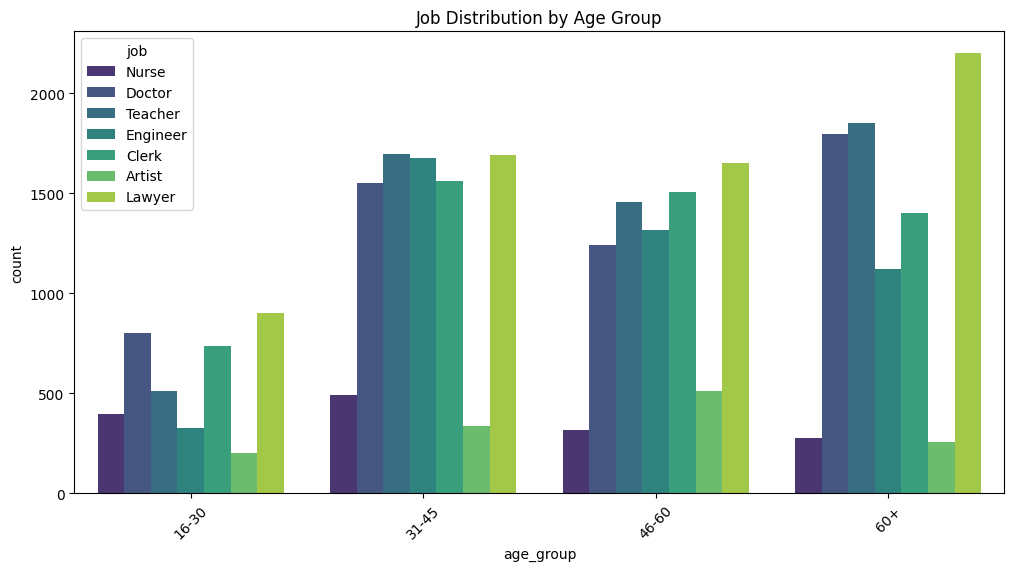

In [24]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

# Bin age into groups
bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')


plt.figure(figsize=(12, 6))
sns.countplot(data=merged_data, x='age_group', hue='job', palette="viridis")
plt.title("Job Distribution by Age Group")
plt.xticks(rotation=45)
plt.show()

merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)



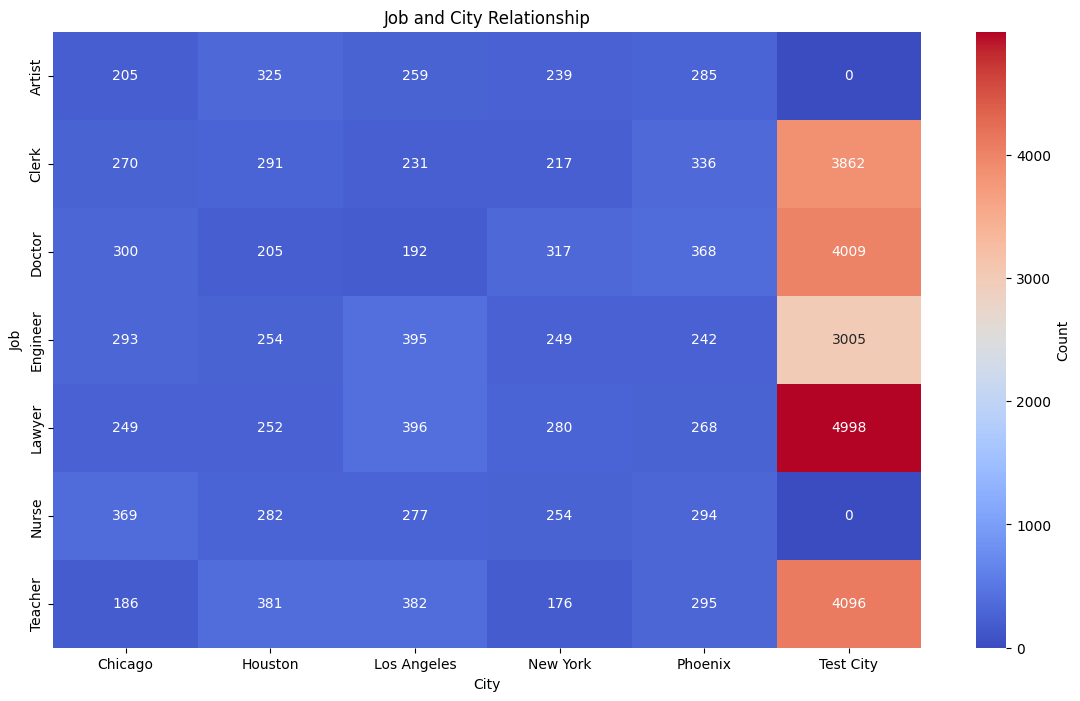

In [25]:
job_merchant = merged_data.groupby(['job', 'city']).size().reset_index(name='count')
pivot = job_merchant.pivot(index='job', columns='city', values='count').fillna(0)
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Count'})
plt.title('Job and City Relationship')
plt.xlabel('City')
plt.ylabel('Job')
plt.show()

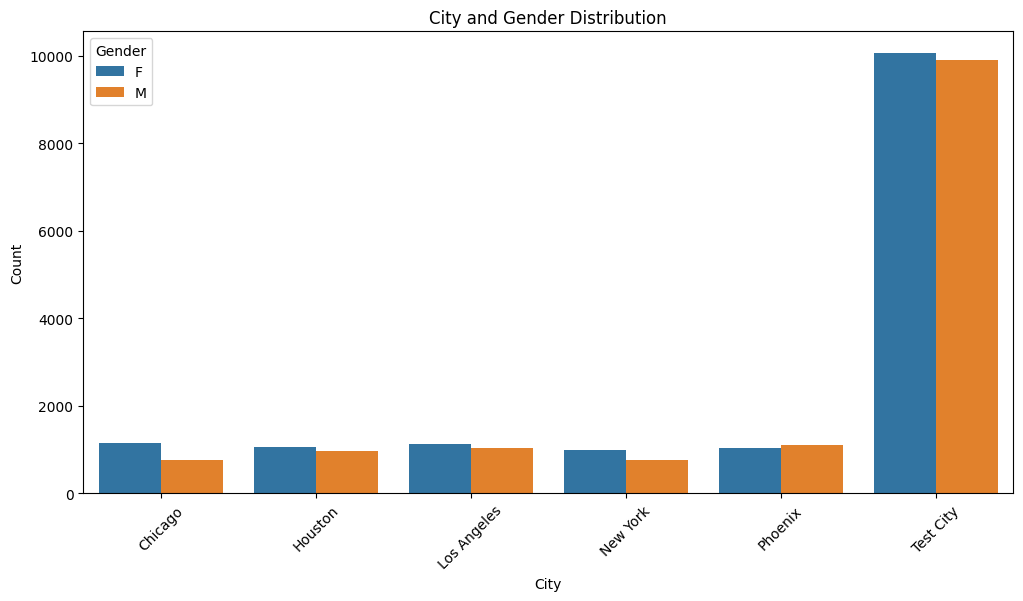

In [26]:
# Convert `unix_time` to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['unix_time'], unit='s')

# Calculate age based on the transaction date
merged_data['age'] = merged_data['transaction_date'] - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

city_gender = merged_data.groupby(['city', 'gender']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(data=city_gender, x='city', y='count', hue='gender')
plt.title('City and Gender Distribution')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()



/tmp/ipykernel_17156/465656370.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_age = merged_data.groupby(['city', 'age_group']).size().reset_index(name='count')


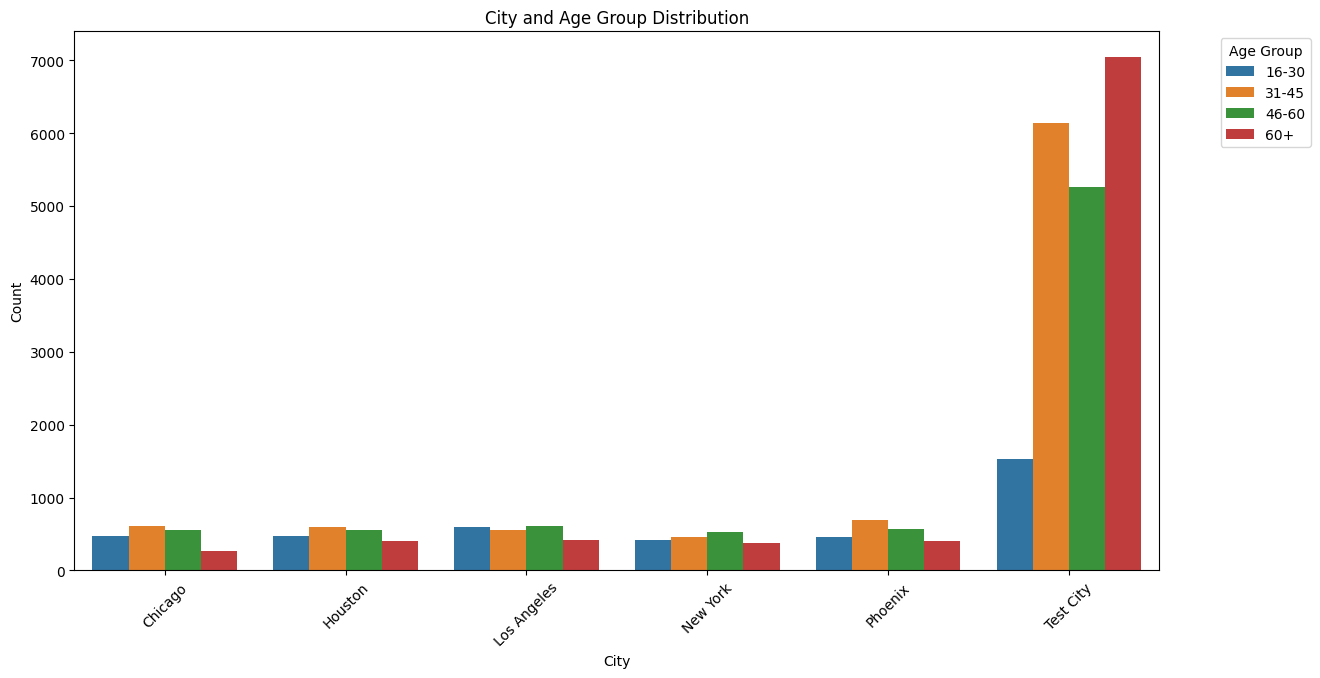

In [27]:
# Bin age into groups
bins = [16, 30, 45, 60, 100]  
labels = ["16-30", "31-45", "46-60", "60+"]  
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

merged_data['age_group'] = merged_data['age_group'].astype('category')

city_age = merged_data.groupby(['city', 'age_group']).size().reset_index(name='count')
plt.figure(figsize=(14, 7))
sns.barplot(data=city_age, x='city', y='count', hue='age_group', dodge=True)
plt.title('City and Age Group Distribution')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


merged_data.drop('age_group', axis=1, inplace=True)
merged_data.drop('age', axis=1, inplace=True)
merged_data.drop('transaction_date', axis=1, inplace=True)


#### Conclusion on Data Visualization

The analysis revealed several key insights about fraudulent transactions. Fraud is relatively rare in the dataset, accounting for only 1.9% of all transactions, highlighting the challenge of identifying such rare events. Geographic patterns showed clusters of fraudulent transactions near major urban centers, though significant outliers and inconsistent coordinates suggest that location data may not be highly reliable. Fraud rates varied by age group, with younger and middle-aged individuals (25-35 and 35-50) being more frequently targeted, particularly in categories like Apparel, Travel, and Entertainment. Older age groups (65+) generally experienced lower fraud rates. Certain categories, such as Travel and Entertainment, showed higher fraud activity, suggesting specific areas where fraudsters exploit vulnerabilities.

## 1.2- Data Preparation

Data preparation is a critical step in the machine learning pipeline, ensuring that the dataset is clean, consistent, and structured for effective modeling. This process involves handling missing values, encoding categorical variables, creating meaningful features, and addressing potential issues like class imbalance. Proper data preparation enhances the quality of the input data, reduces noise, and helps models better capture underlying patterns. In this project, the data preparation phase focuses on transforming the provided transaction data into a format suitable for building a predictive model to detect fraudulent transactions. This includes cleaning the dataset, engineering new features, scaling numerical variables, and addressing the imbalanced nature of the target variable. These steps aim to improve the accuracy and reliability of the predictive models in identifying fraud.

The data preparation process outlined below reflects the process I used for the final models, but it is important to note that this was a long and iterative journey. It required significant fine-tuning and adjustments to reach the final version. In the initial stages, I made mistakes that negatively impacted the model's performance, such as choosing inappropriate scalers, selecting variables poorly, or applying encoding techniques that did not align with the data. These errors were instrumental in the learning process, and by identifying the issues, I refined the techniques I used. In this section, I will explain the strategies I adopted to reach this version and the mistakes I made along the way.

### 1.2.1- Split Data into Train and Test Sets

In [28]:

merged_data['is_fraud'] = merged_data['is_fraud'].astype('category') # had to be done to run on SMOTE


X = merged_data.drop('is_fraud', axis=1)
y = merged_data['is_fraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #explicar o stratify que garante que tenha a mesma quantidade de fraude e n fraude

### 1.2.2- Handle Duplicate Values

In [29]:
# Check for duplicate transactions
print("\nDuplicate Transactions:")
print(X_train.duplicated(subset='trans_num').sum())



Duplicate Transactions:
337



A function `remove_duplicates` was implemented to identify and remove duplicate transactions based on the `trans_num` attribute. For duplicates with the same `trans_num`, the row with fewer missing values (i.e., fewer NaNs) was retained, ensuring the preservation of the most complete record. The cleaned dataset was returned for both `X_train` (features) and `y_train` (target variable).


In [30]:
# Delete duplicate transactions 
def remove_duplicates(dataframe,dataframe2):
  
    duplicated = dataframe[dataframe.duplicated(subset='trans_num', keep=False)]

    indices_to_keep = (
        duplicated
        .groupby('trans_num')
        .apply(lambda group: group.isnull().sum(axis=1).idxmin())  # Rows with more NaNs
    )

    indices_to_remove = set(duplicated.index) - set(indices_to_keep)

    dataframe_cleaned = dataframe.drop(index=indices_to_remove)
    dataframe2_cleaned = dataframe2.drop(index=indices_to_remove)
    
    return dataframe_cleaned.reset_index(drop=True), dataframe2_cleaned.reset_index(drop=True)

X_train, y_train = remove_duplicates(X_train,y_train)


# Check for duplicate transactions
print("\nDuplicate Transactions:")
print(X_train.duplicated(subset='trans_num').sum())



Duplicate Transactions:
0


/tmp/ipykernel_17156/3258083248.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.isnull().sum(axis=1).idxmin())  # Rows with more NaNs


### 1.2.3- Feature Engineering

In [31]:
def calculate_age_and_groups(data):
   # Convert `unix_time` to datetime
    data['transaction_date'] = pd.to_datetime(data['unix_time'], unit='s')

    # Calculate age based on the transaction date
    data['age'] = data['transaction_date'] - pd.to_datetime(data['dob'])
    data['age'] = data['age'].dt.days // 365

    bins = [16, 30, 45, 60, 100]  
    labels = ["16-30", "31-45", "46-60", "60+"]  
    data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

    data['age_group'] = data['age_group'].astype('object')


    return data


X_train = calculate_age_and_groups(X_train)
X_test = calculate_age_and_groups(X_test)



In [32]:
def create_feature(data, new_feature, atr1, atr2):
    data[new_feature] = (
        data[atr1] + '_' + data[atr2].astype(str)
    )

create_feature(X_train,'job_age_group','job','age_group')
create_feature(X_test,'job_age_group','job','age_group')


X_train['transaction_hour'] = X_train['transaction_date'].dt.hour
X_test['transaction_hour'] = X_test['transaction_date'].dt.hour

X_train['hour_sin'] = np.sin(2 * np.pi * X_train['transaction_hour'] / 24)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['transaction_hour'] / 24)
X_test['hour_sin'] = np.sin(2 * np.pi * X_test['transaction_hour'] / 24)
X_test['hour_cos'] = np.cos(2 * np.pi * X_test['transaction_hour'] / 24)


### 1.2.4- Drop Redundant or Unnecessary Columns

| Column                  | Reason for Removal                                                                                              | Expected Impact                                                                                     |
|--------------------------|---------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| `index`                 | Serves only as a transaction index and provides no informative value for prediction.                           | No impact on the model as it carries no predictive value.                                           |
| `trans_num`             | Functions as a unique transaction identifier without contributing to fraud prediction.                         | No impact, as it does not provide meaningful information for the model.                            |
| `trans_date_trans_time` | Redundant with `unix_time`, which is more accurate and has fewer missing values.                               | Simplifies the dataset without losing meaningful information.                                       |
| `zip`                   | Granular location detail is unnecessary; broader attributes like `city` are more useful.                      | Reduces unnecessary granularity in the dataset.                                                    |
| `first`, `last`         | Personal data irrelevant for fraud prediction and may violate privacy.                                         | Improves privacy compliance and removes irrelevant variables.                                       |
| `street`                | Detailed location information is not relevant; higher-level attributes like `city` suffice.                   | Reduces dataset complexity by removing unnecessary attributes.                                      |
| `state`                 | Not necessary for prediction as broader geographic features like `city_pop` are more impactful.               | Simplifies the dataset while retaining relevant geographic information.                            |
| `lat`, `long`           | Latitude and longitude information is indirectly reflected in attributes like `city_pop` and `city`.           | Reduces dimensionality without significant loss of information.                                     |
| `merch_lat`, `merch_long`| Redundant for fraud prediction as geographic patterns can be inferred from broader attributes.                | Simplifies the dataset by removing granular geographic details.                                     |
| `merchant`              | Redundant with `merchant_id`, which is already a numerical attribute and provides sufficient information.      | Reduces redundancy and ensures model focus on more predictive features.                            |
| `dob`                   | Used to create `age`, which is a more practical variable for analysis.                                         | Eliminates redundancy as `age` already captures the relevant information from `dob`.               |
| `cc_num`                | Functions solely as an identifier and does not contribute to prediction.                                       | No impact on the model as it carries no predictive value.                                           |
| `age`                   | Used to create `age_group`, which is a more generalized and useful feature for fraud prediction.               | Reduces redundancy by focusing on broader, more relevant categories.                               |
| `unix_time`             | Redundant with `transaction_hour` and other time-related attributes derived from it.                          | Avoids duplication and streamlines time-based analysis.                                             |
| `transaction_hour`      | Already reflected in broader time-based variables like `transaction_date`.                                     | Simplifies the dataset by removing derived attributes.                                              |
| `transaction_date`      | Provides redundant information that is not directly useful for prediction.                                     | Reduces complexity without affecting model accuracy.                                                |
| `merchant_id`           | Already encoded and processed, so the raw variable is unnecessary.                                             | Simplifies the dataset without losing important information.                                        |


In [33]:
X_train.drop(['index','trans_num','trans_date_trans_time','zip','first','last','street','state',
                  'lat','long','merch_lat','merch_long','merchant','dob','cc_num','age','unix_time','transaction_hour','transaction_date','merchant_id'], axis=1, inplace=True)

X_test.drop(['index','trans_num','trans_date_trans_time','zip','first','last','street','state',
                  'lat','long','merch_lat','merch_long','merchant','dob','cc_num','age','unix_time','transaction_hour','transaction_date','merchant_id'], axis=1, inplace=True)



### 1.2.5- Handle Missing Values

In [34]:
# Check for missing values
print("\nMissing Values Train:")
print(X_train.isnull().sum())

X_train.to_csv('X_train_with_missing_values.csv', index=False)



Missing Values Train:
device_os        14107
amt                 78
gender               1
city                 1
job                162
category           447
city_pop         15636
age_group            1
job_age_group      162
hour_sin             0
hour_cos             0
dtype: int64


In [35]:
X_train = pd.read_csv('X_train_without_missing_values.csv')


# Check for missing values
print("\nMissing Values Train:")
print(X_train.isnull().sum())



Missing Values Train:
device_os        0
amt              0
gender           0
city             0
job              0
category         0
city_pop         0
age_group        0
job_age_group    0
hour_sin         0
hour_cos         0
dtype: int64


In [36]:
print("\nMissing Values Test:")
print(X_test.isnull().sum())


Missing Values Test:
device_os        3615
amt                21
gender              1
city                1
job                45
category          135
city_pop         4060
age_group           1
job_age_group      45
hour_sin            0
hour_cos            0
dtype: int64


In [37]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns


train_means = X_train[numeric_cols].mean()


train_modes = X_train[categorical_cols].mode().iloc[0]

for col in numeric_cols:
    if col in X_test.columns: 
        X_test[col] = X_test[col].fillna(train_means[col])

for col in categorical_cols:
    if col in X_test.columns:  
        X_test[col] = X_test[col].fillna(train_modes[col])

print("\nMissing Values Test:")
print(X_test.isnull().sum())


Missing Values Test:
device_os        0
amt              0
gender           0
city             0
job              0
category         0
city_pop         0
age_group        0
job_age_group    0
hour_sin         0
hour_cos         0
dtype: int64


In [38]:
X_train.head()

,device_os,amt,gender,city,job,category,city_pop,age_group,job_age_group,hour_sin,hour_cos
0,macOS,328.06,F,Test City,Doctor,Apparel,2716000,31-45,Doctor_31-45,0.866025,-0.500000
1,other,313.53,M,Test City,Clerk,Electronics,2716000,46-60,Clerk_46-60,0.258819,0.965926
2,other,255.81,F,Test City,Teacher,Electronics,2716000,60+,Teacher_60+,0.258819,0.965926
3,Linux,222.52,F,Phoenix,Doctor,Groceries,1680992,60+,Doctor_60+,-0.707107,-0.707107
4,other,117.32,F,Test City,Engineer,Electronics,2716000,60+,Engineer_60+,0.258819,0.965926


In [39]:
X_test.head()

,device_os,amt,gender,city,job,category,city_pop,age_group,job_age_group,hour_sin,hour_cos
24161,Windows,31.20,M,Test City,Lawyer,Apparel,3.076707e+06,16-30,Lawyer_16-30,-0.965926,-2.588190e-01
2107,Windows,139.18,M,Los Angeles,Artist,Groceries,3.979576e+06,46-60,Artist_46-60,0.965926,2.588190e-01
27695,X11,297.05,F,Test City,Lawyer,Travel,3.076707e+06,46-60,Lawyer_46-60,-0.258819,9.659258e-01
11110,Windows,122.39,M,Test City,Clerk,Travel,3.076707e+06,46-60,Clerk_46-60,-0.258819,-9.659258e-01
28450,Windows,413.40,F,Test City,Teacher,Entertainment,3.076707e+06,31-45,Teacher_31-45,-1.000000,-1.836970e-16


### 1.2.6- Encode Categorical Variables


The function `one_hot_encoding` was implemented to perform one-hot encoding on all categorical columns in a dataset. It specifically checks for categorical columns with two unique categories and applies the `drop_first` option only to those, while encoding all other categorical variables fully. Here's how it works step-by-step:


In [40]:
# One-hot encoding example

def one_hot_encoding(data):
    print("##########################")
    columns= data.select_dtypes(include=["object"]).columns.tolist()

    for column in columns:
        
        unique_categories = data[column].nunique()

        
        drop_first = unique_categories == 2

        print(column + ": Drop_first " + str(drop_first))

      
        data = pd.get_dummies(data, columns=[column], drop_first=drop_first)
        
    return data

X_train = one_hot_encoding(X_train)
X_test = one_hot_encoding(X_test)

"""
X_train = X_train.rename(columns={
    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',
    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'
})

X_test = X_test.rename(columns={
    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',
    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'
})
"""

##########################
device_os: Drop_first False
gender: Drop_first True
city: Drop_first False
job: Drop_first False
category: Drop_first False
age_group: Drop_first False
job_age_group: Drop_first False
##########################
device_os: Drop_first False
gender: Drop_first True
city: Drop_first False
job: Drop_first False
category: Drop_first False
age_group: Drop_first False
job_age_group: Drop_first False


"\nX_train = X_train.rename(columns={\n    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',\n    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'\n})\n\nX_test = X_test.rename(columns={\n    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',\n    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'\n})\n"

In [41]:
X_train.head()

,amt,city_pop,hour_sin,hour_cos,device_os_Linux,device_os_Windows,device_os_X11,device_os_macOS,device_os_other,gender_M,...,job_age_group_Lawyer_46-60,job_age_group_Lawyer_60+,job_age_group_Nurse_16-30,job_age_group_Nurse_31-45,job_age_group_Nurse_46-60,job_age_group_Nurse_60+,job_age_group_Teacher_16-30,job_age_group_Teacher_31-45,job_age_group_Teacher_46-60,job_age_group_Teacher_60+
0,328.06,2716000,0.866025,-0.500000,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,313.53,2716000,0.258819,0.965926,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,255.81,2716000,0.258819,0.965926,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,222.52,1680992,-0.707107,-0.707107,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,117.32,2716000,0.258819,0.965926,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [42]:
X_test.head()

,amt,city_pop,hour_sin,hour_cos,device_os_Linux,device_os_Windows,device_os_X11,device_os_macOS,device_os_other,gender_M,...,job_age_group_Lawyer_46-60,job_age_group_Lawyer_60+,job_age_group_Nurse_16-30,job_age_group_Nurse_31-45,job_age_group_Nurse_46-60,job_age_group_Nurse_60+,job_age_group_Teacher_16-30,job_age_group_Teacher_31-45,job_age_group_Teacher_46-60,job_age_group_Teacher_60+
24161,31.20,3.076707e+06,-0.965926,-2.588190e-01,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2107,139.18,3.979576e+06,0.965926,2.588190e-01,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
27695,297.05,3.076707e+06,-0.258819,9.659258e-01,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
11110,122.39,3.076707e+06,-0.258819,-9.659258e-01,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
28450,413.40,3.076707e+06,-1.000000,-1.836970e-16,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


### 1.2.7- Normalize/Scale Numerical Features

Initially, I planned to use StandardScaler to standardize the data, assuming it followed a normal distribution. However, since StandardScaler performs best with normally distributed data, I decided to check the distribution of the variables using histograms. 

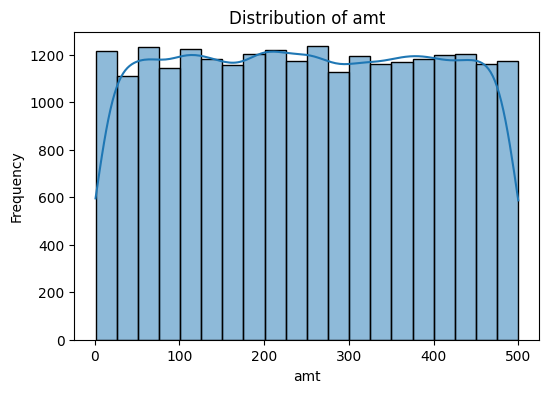

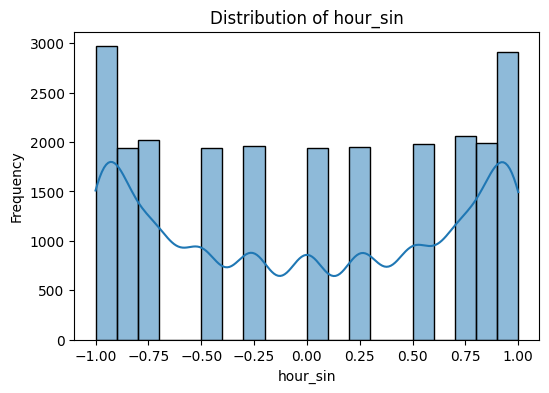

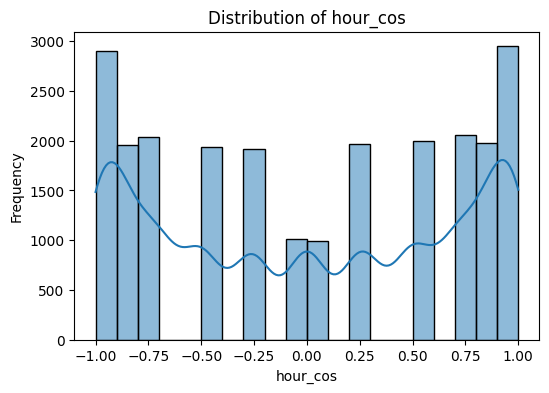

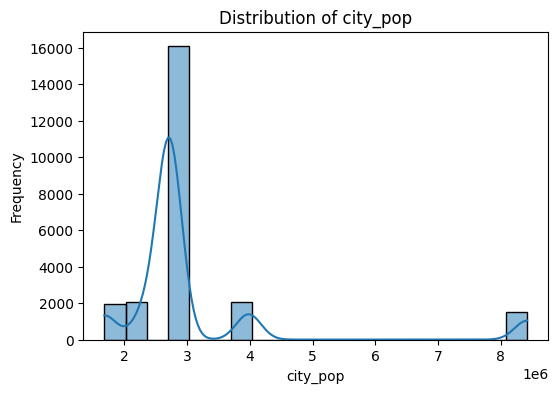

In [43]:
numerical_columns = ['amt','hour_sin','hour_cos','city_pop']
for col in X_train[numerical_columns]:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

After analyzing the plots, I realized that the data did not follow a normal distribution. Therefore, I opted for MinMaxScaler, which preserves the original shape of the data and scales the values to the range [0, 1].

In [44]:
numerical_columns = ['amt','hour_sin','hour_cos','city_pop'] 
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])


In [45]:
with open("variables/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("variables/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("variables/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("variables/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

## 1.3- Clustering

### 1.3.1- DBSCAN

DBSCAN identified 2 clusters (excluding noise).


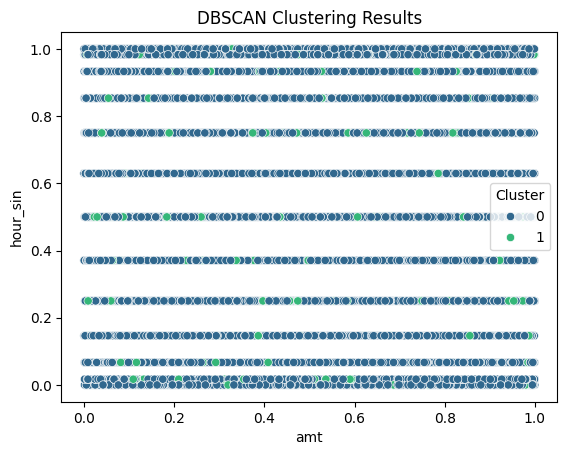

Silhouette Score for DBSCAN (excluding noise): 0.4977241746140008


In [46]:

# Select numerical features for clustering
features = ['amt','hour_sin', 'hour_cos','city_pop']  # Replace with features relevant to your data
data_subset = X_train[features].copy()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust `eps` and `min_samples` as needed
clusters = dbscan.fit_predict(data_subset)

# Add cluster labels to the dataset
data_subset['cluster'] = clusters

# Check the number of clusters in DBSCAN
n_clusters_dbscan = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"DBSCAN identified {n_clusters_dbscan} clusters (excluding noise).")

# Plot the DBSCAN results
sns.scatterplot(x=data_subset[features[0]], y=data_subset[features[1]], hue=data_subset['cluster'], palette='viridis')
plt.title("DBSCAN Clustering Results")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(title='Cluster')
plt.show()

# 5. Evaluate Clusters
# Silhouette Score for DBSCAN (excluding noise)
dbscan_silhouette = silhouette_score(data_subset[clusters != -1], clusters[clusters != -1]) if n_clusters_dbscan > 1 else "N/A"
print(f"Silhouette Score for DBSCAN (excluding noise): {dbscan_silhouette}")


The clustering results suggest potential patterns in the data based on the combination of transaction amount (`amt`) and time (`hour_sin`).

- **Cluster 1:** This cluster might correspond to a specific behavioral or transactional pattern, possibly representing anomalies or distinct types of transactions.
- **Cluster 0:** This cluster likely represents more general patterns in the data, encompassing the majority of the transactions.

The moderate silhouette score (**0.4977**) indicates that the clustering is reasonable but leaves room for improvement. Possible ways to enhance clustering performance include:

- **Feature Engineering:** Adding or transforming features to better capture relationships in the data.
- **Parameter Tuning:** Adjusting DBSCAN hyperparameters such as `eps` (neighborhood radius) and `min_samples` (minimum points to form a cluster) to refine the clustering results.


### 1.3.2- K-Means

Best k for K-Means: 9, Silhouette Score: 0.3263908139525744


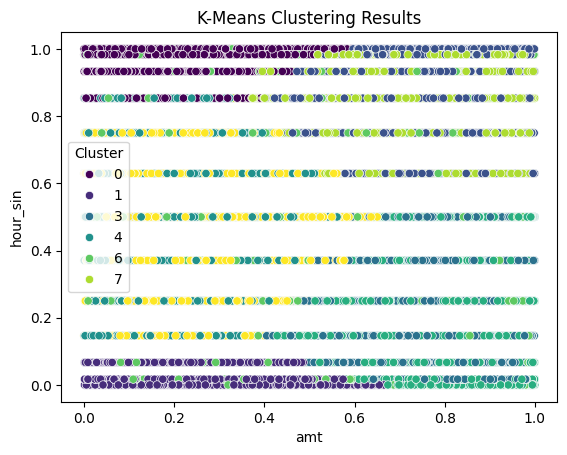

In [47]:

features = ['amt','hour_sin', 'hour_cos','city_pop']  # Replace with features relevant to your data
X_temp = X_train[features].copy()

# Test different numbers of clusters (k)
k_range = range(2, 10)
kmeans_results = {}
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_temp)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_temp, labels)
    kmeans_results[k] = silhouette_avg

# Select the best k (highest silhouette score)
best_k = max(kmeans_results, key=kmeans_results.get)
print(f"Best k for K-Means: {best_k}, Silhouette Score: {kmeans_results[best_k]}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_temp)
X_temp['kmeans_cluster'] = kmeans_labels

# Plot the K-Means results
sns.scatterplot(x=X_temp[features[0]], y=X_temp[features[1]], hue=kmeans_labels, palette='viridis')
plt.title("K-Means Clustering Results")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(title='Cluster')
plt.show()




## 1.4- Kaggle dataset preparation 

In [48]:
transactions = pd.read_csv('kaggle-data/test_transactions.csv')
merchants = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/merchants.csv')
customers = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/customers.csv')
cities = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/cities.csv')

# Merge the .csv files into one
kaggle_data = pd.merge(transactions, customers, on='cc_num', how='left')
kaggle_data = pd.merge(kaggle_data, merchants, on='merchant', how='left')
kaggle_data = pd.merge(kaggle_data, cities, on='city', how='left')

kaggle_data['index'] = kaggle_data['index'].astype('object')
kaggle_data['cc_num'] = kaggle_data['cc_num'].astype('object')
kaggle_data['zip'] = kaggle_data['zip'].astype('object')
kaggle_data['merchant_id'] = kaggle_data['merchant_id'].astype('object')


In [49]:
kaggle_data = calculate_age_and_groups(kaggle_data)

In [50]:

create_feature(kaggle_data,'job_age_group','job','age_group')


kaggle_data['transaction_hour'] =  kaggle_data['transaction_date'].dt.hour

kaggle_data['hour_sin'] = np.sin(2 * np.pi * kaggle_data['transaction_hour'] / 24)
kaggle_data['hour_cos'] = np.cos(2 * np.pi *  kaggle_data['transaction_hour'] / 24)



In [51]:
index_mapping = kaggle_data['index'].values


kaggle_data.drop(['index','trans_num','trans_date_trans_time','zip','first','last','street','state',
                  'lat','long','merch_lat','merch_long','merchant','dob','cc_num','age','unix_time','transaction_hour','transaction_date','merchant_id'], axis=1, inplace=True)



The code fills missing values in the `kaggle_data` dataset by leveraging the statistics (mean or mode) calculated from the training dataset (`X_train`).

In [52]:

for col in numeric_cols:
    if col in kaggle_data.columns:  
        kaggle_data[col] = kaggle_data[col].fillna(train_means[col])

for col in categorical_cols:
    if col in kaggle_data.columns: 
        kaggle_data[col] = kaggle_data[col].fillna(train_modes[col])


In [53]:

kaggle_data = one_hot_encoding(kaggle_data)


kaggle_data.insert(4,'device_os_Linux',False)


# NOTE: I had to rename the macOs device from the "test_transactions" to macOS to be the same as the trained model


##########################
device_os: Drop_first False
gender: Drop_first True
city: Drop_first False
job: Drop_first False
category: Drop_first False
age_group: Drop_first False
job_age_group: Drop_first False


In [54]:
kaggle_data.head()


,amt,city_pop,hour_sin,hour_cos,device_os_Linux,device_os_Windows,device_os_X11,device_os_macOS,device_os_other,gender_M,...,job_age_group_Lawyer_46-60,job_age_group_Lawyer_60+,job_age_group_Nurse_16-30,job_age_group_Nurse_31-45,job_age_group_Nurse_46-60,job_age_group_Nurse_60+,job_age_group_Teacher_16-30,job_age_group_Teacher_31-45,job_age_group_Teacher_46-60,job_age_group_Teacher_60+
0,237.193397,3979576.0,0.0,1.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,111.790842,3979576.0,0.0,1.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,263.236625,2716000.0,0.0,1.0,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,355.424471,1680992.0,0.0,1.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,252.471612,3979576.0,0.0,1.0,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False


In [55]:
with open("variables/kaggle_data.pkl", "wb") as f:
    pickle.dump(kaggle_data, f)

with open("variables/index_mapping.pkl", "wb") as f:
    pickle.dump(index_mapping, f)
